Sampling at 20kHz

Want to accurately capture signals as low as 20Hz

Input Size - 1024 Points



In [5]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras as keras
from keras.legacy import interfaces

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live
import tflite_runtime.interpreter as tflite

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 4)

from scipy.stats import probplot
from scipy.stats import normaltest


from scipy import signal

import os
import pandas as pd
from ML_Train.DBQuerier import DBQuerier as Querier
from sklearn.model_selection import train_test_split
from crawlab_toolbox import plotting as genplt


gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)



%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [35]:
dataPoints = 4096

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train_healthy = X_train[first_good_train:,:dataPoints]
X_valid_healthy = X_test[first_good_test:,:dataPoints]
X_train_unhealthy = X_train[:first_good_train,:dataPoints]
X_valid_unhealthy = X_test[:first_good_test,:dataPoints]

X_train_healthy = X_train_healthy.reshape(X_train_healthy.shape[0] * 4,int(X_train_healthy.shape[1] / 4))
X_valid_healthy = X_valid_healthy.reshape(X_valid_healthy.shape[0] * 4,int(X_valid_healthy.shape[1] / 4))
X_train_unhealthy = X_train_unhealthy.reshape(X_train_unhealthy.shape[0] * 4,int(X_train_unhealthy.shape[1] / 4))
X_valid_unhealthy = X_valid_unhealthy.reshape(X_valid_unhealthy.shape[0] * 4,int(X_valid_unhealthy.shape[1] / 4))


np.random.shuffle(X_train_healthy)
np.random.shuffle(X_valid_healthy)
np.random.shuffle(X_train_unhealthy)
np.random.shuffle(X_valid_unhealthy)

X = []

X.append(X_train_healthy)
X.append(X_valid_healthy)
X.append(X_train_unhealthy)
X.append(X_valid_unhealthy)

for i in range(len(X)):
    X[i] = (X[i] + 2.5) / 5

In [36]:
print(np.amin(X[0]))
print(np.amin(X[1]))
print(np.amin(X[2]))
print(np.amin(X[3]))

print(np.amax(X[0]))
print(np.amax(X[1]))
print(np.amax(X[2]))
print(np.amax(X[3]))

0.03622999
0.034185983
0.014504003
0.04594202
0.90294
0.89680594
0.922108
0.893226


In [107]:
def normalize_scores(scores,log_prob=False):

    flat = np.array([])
    for i in range(len(scores)):
        flat = np.append(flat,scores[i])
    
    max_val = np.amax(flat)
    
    if log_prob:
        scores = [np.log(np.abs(scores[i] - 1.1 * max_val)) for i in range(len(scores))]
    

    norm_mean = np.mean(scores[0])
    norm_std = np.std(scores[0])
    
    scores = [(scores[i] - norm_mean) / norm_std for i in range(len(scores))]
    
    [print(normaltest(scores[i])) for i in range(len(scores))]
    [print(np.std(scores[i]), np.mean(scores[i])) for i in range(len(scores))]
    
    return scores

import numpy as np

from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_encoder(
                   filters, 
                   kernels, 
                   strides,
                   dilation_rates,
                   input_shape
                   ):
    
    encoder = Sequential()
    
    for i in range(len(filters)):
        if i == 0:
            encoder.add(Conv1D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='relu', 
                               padding='same',
                               dilation_rate=dilation_rates[i],
                               input_shape=input_shape))
        else:
            encoder.add(Conv1D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='relu', 
                               padding='same',
                               dilation_rate=dilation_rates[i]))
#         encoder.add(BatchNormalization())
        encoder.add(Dropout(0.3))
        encoder.add(MaxPooling1D(2))
        
    return encoder

def create_decoder(
                   filters,
                   kernels,
                   strides,
                   dilation_rates,
                   ):
    
    decoder = Sequential()
    
    filters.reverse()
    kernels.reverse()
    strides.reverse()
    dilation_rates.reverse()
    
    decoder.add(UpSampling1D(2))
    
    for i in range(1,len(filters)):
        decoder.add(Conv1D(filters=filters[i], 
                           kernel_size=kernels[i], 
                           strides=strides[i], 
                           activation='relu', 
                           padding='same',
                           dilation_rate=dilation_rates[i]))
#         decoder.add(Dropout(0.5))
        decoder.add(UpSampling1D(2))
    
    #decoder.add(Dropout_Live(0.5))
    decoder.add(Conv1D(1, 3, 1, activation='sigmoid', padding='same'))
    
    return decoder
    
def create_autoencoder(param_dict):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
        
    encoder = create_encoder(filters,kernels,strides,dilation_rates,input_shape)
    decoder = create_decoder(filters,kernels,strides,dilation_rates)
    
    stacked_ae = Sequential([encoder, decoder])

    return stacked_ae,encoder,decoder
    

In [108]:
if os.path.isfile('data/CNN-AE.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('data/CNN-AE.h5')
    print(model.summary())
else:
    filters=[16,16,16]
    kernels = [3,5,7]
    strides=[1,1,1,1,1,1]
    dilation_rates=[1,1,1,1,1,1]
    input_shape = [1024,1]

    param_dict = {
        "filters":filters,
        "kernels":kernels,
        "strides":strides,
        "dilation_rates":dilation_rates,
        "input_shape":input_shape,
    }

    model,encoder,decoder = create_autoencoder(param_dict)

    model.compile(loss='mean_squared_error',optimizer='adam')
    history = model.fit(X[0][...,np.newaxis],X[0][...,np.newaxis],
                        epochs=10,batch_size=4,
                        validation_split=0.2,verbose=1,
    #                     validation_data=[X_healthy_test[...,np.newaxis],X_healthy_test[...,np.newaxis]]
                       )
    
#     model.save('data/CNN-AE.h5',save_format='tf')


# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# open(os.path.join('data', 'CNN-AE.tflite',),
#      "wb").write(tflite_model)

X_conv_ae = []
mse_conv_ae = []

for i in range(len(X)):
    X_conv_ae.append(np.squeeze(model.predict(X[i][...,np.newaxis])))
    mse_conv_ae.append(keras.metrics.mean_squared_error(X_conv_ae[i],X[i]))


Train on 480 samples, validate on 120 samples
Epoch 1/10
480/480 [==============================] - 3s 6ms/sample - loss: 0.0091 - val_loss: 0.0072
Epoch 2/10
480/480 [==============================] - 1s 2ms/sample - loss: 0.0048 - val_loss: 0.0058
Epoch 3/10
480/480 [==============================] - 1s 2ms/sample - loss: 0.0040 - val_loss: 0.0049
Epoch 4/10
480/480 [==============================] - 1s 2ms/sample - loss: 0.0037 - val_loss: 0.0045
Epoch 5/10
480/480 [==============================] - 1s 2ms/sample - loss: 0.0035 - val_loss: 0.0044
Epoch 6/10
480/480 [==============================] - 1s 2ms/sample - loss: 0.0033 - val_loss: 0.0040
Epoch 7/10
480/480 [==============================] - 1s 2ms/sample - loss: 0.0031 - val_loss: 0.0037
Epoch 8/10
480/480 [==============================] - 1s 2ms/sample - loss: 0.0030 - val_loss: 0.0034
Epoch 9/10
480/480 [==============================] - 1s 2ms/sample - loss: 0.0029 - val_loss: 0.0032
Epoch 10/10
480/480 [===============

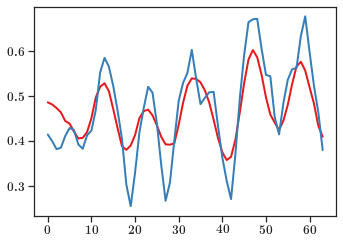

In [109]:
plt.plot(X_conv_ae[0][0,:64])
plt.plot(X[0][0,:64])

In [110]:

norm_conv_ae = normalize_scores(mse_conv_ae,False)

NormaltestResult(statistic=257.69985900077876, pvalue=1.0994782040188595e-56)
NormaltestResult(statistic=219.90059545512906, pvalue=1.774975706135791e-48)
NormaltestResult(statistic=430.7193592980109, pvalue=2.9544694524929385e-94)
NormaltestResult(statistic=31.263164476346542, pvalue=1.6266349170264997e-07)
1.0 -1.748403e-07
2.351951 0.62546957
3.6825926 0.78467345
0.7634718 0.11602295


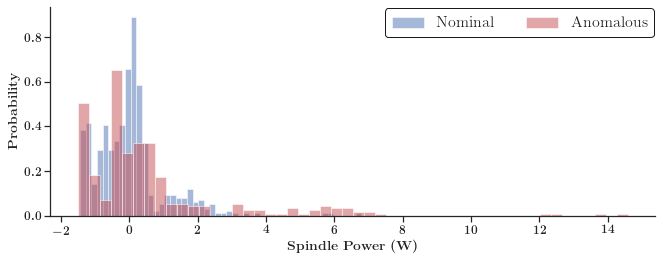

In [111]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(norm_conv_ae[0], 50, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(norm_conv_ae[1], 50, density=True, facecolor='r', alpha=0.50,label='Anomalous')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Spindle Power (W)}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
plt.savefig('figures/Spindle_Load_Anomalous_Compare.png',transparent=True)     
plt.show()

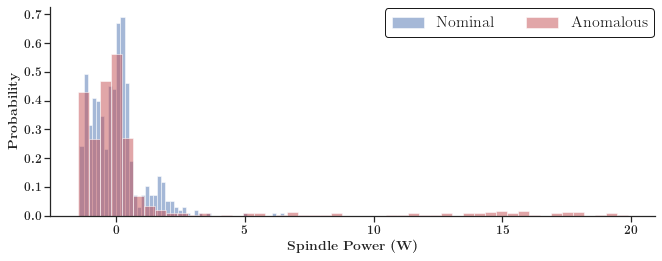

In [103]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(norm_conv_ae[0], 50, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(norm_conv_ae[2], 50, density=True, facecolor='r', alpha=0.50,label='Anomalous')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Spindle Power (W)}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
plt.savefig('figures/Spindle_Load_Anomalous_Compare.png',transparent=True)     
plt.show()

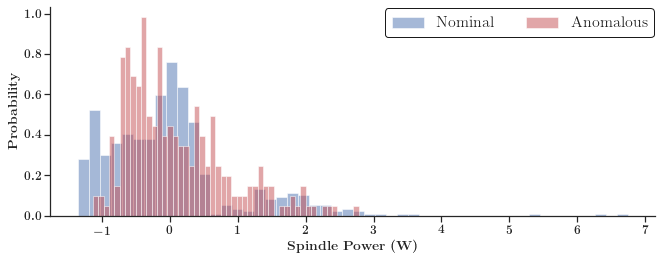

In [98]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(norm_conv_ae[0], 50, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(norm_conv_ae[3], 50, density=True, facecolor='r', alpha=0.50,label='Anomalous')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Spindle Power (W)}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
plt.savefig('figures/Spindle_Load_Anomalous_Compare.png',transparent=True)     
plt.show()